





 Rescaling dataset...



 Splitting into training and test data...



 Preparing train and test series...



 Plotting Training and Test data...


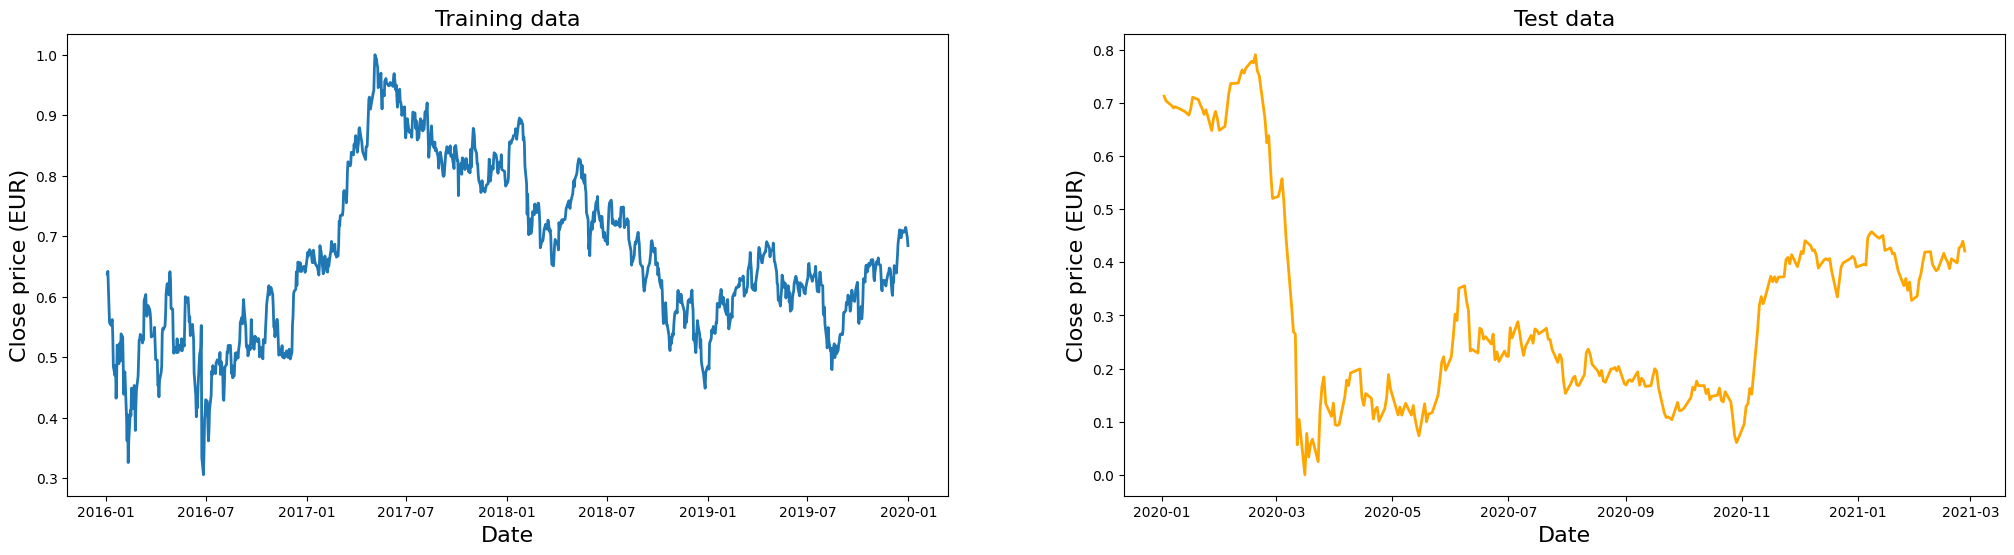




 Preparing training dataset...



 Building LSTM model...



 Training the model...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()





 Making predictions...
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step



 Visualizing results...


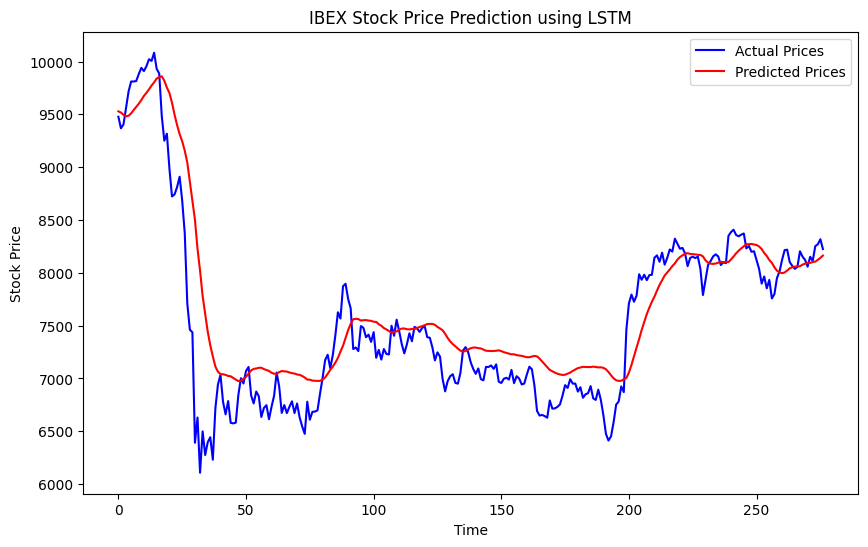




 Plotting test data vs predictions...


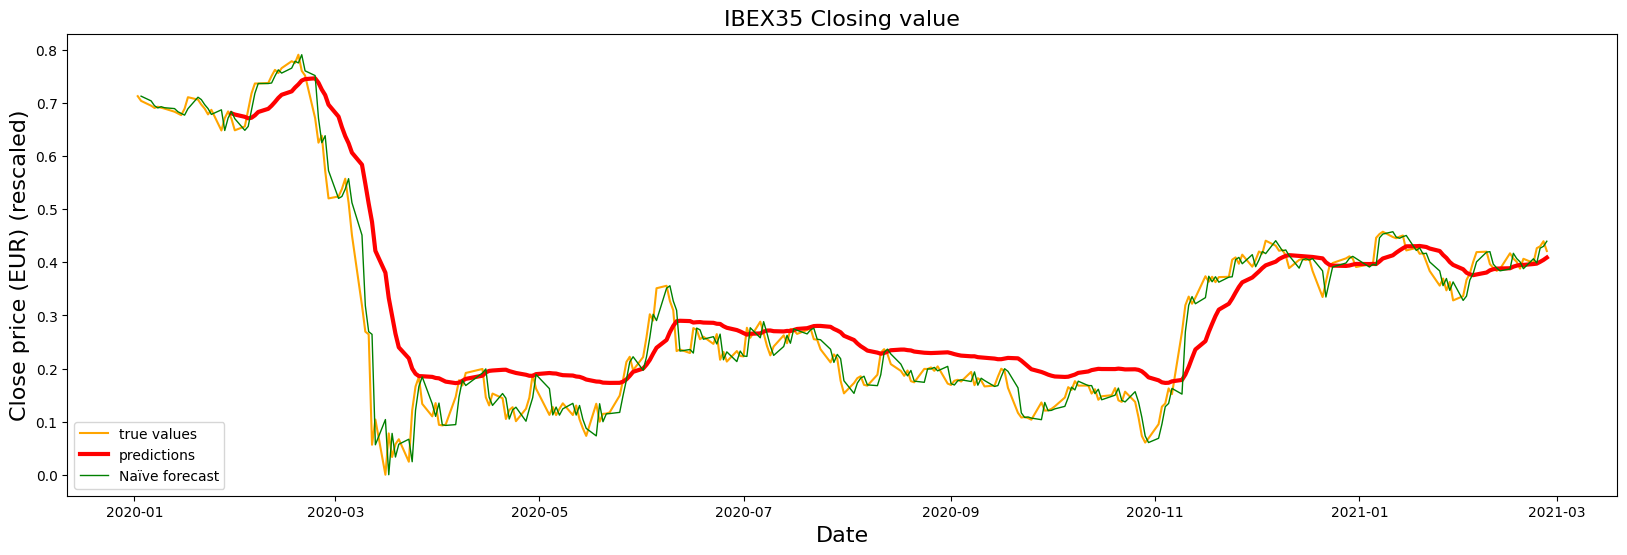




 Adding naive forecast...



 Evaluating models...
Naïve model MSE: 0.0009
LSTM model  MSE: 0.0063
Naïve model MAE: 0.0151
LSTM model  MAE: 0.0463



 Analyzing daily percentage change...


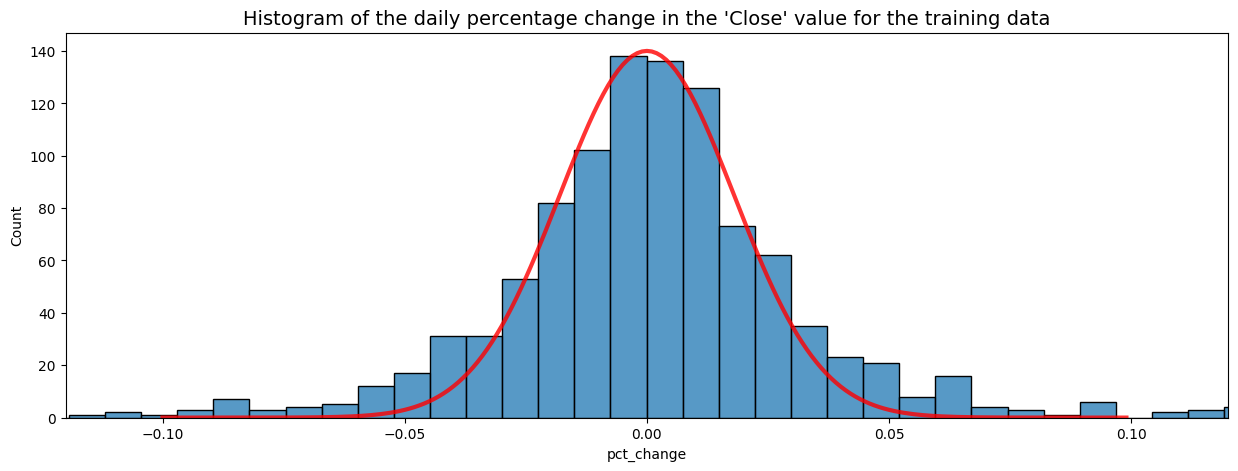




 Generating autocorrelation plot...


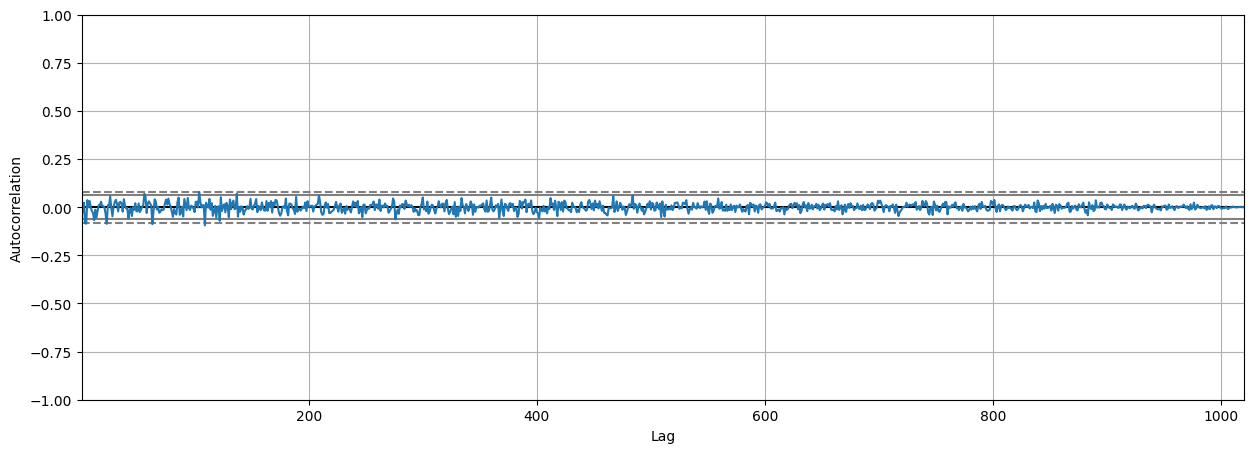

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns
from matplotlib import rcParams
from sklearn.metrics import mean_squared_error, median_absolute_error

# Step 1: Download IBEX stock price data using yfinance
print("\n" * 3, "Downloading IBEX stock price data...")
IBEX = yf.Ticker("^IBEX")
IBEX_values = IBEX.history(start="2016-01-01", end="2021-03-01")
IBEX_values.index = pd.to_datetime(IBEX_values.index).tz_localize(None)

print("\n" * 3, "Rescaling dataset...")
# Step 2: Rescale the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
IBEX_values['Close'] = scaler.fit_transform(IBEX_values[['Close']])

data = IBEX_values[['Close']]

print("\n" * 3, "Splitting into training and test data...")
# Step 3: Split into training and test data
train_data = IBEX_values[IBEX_values.index < "2020-01-01"].reset_index(drop=False)
test_data  = IBEX_values[IBEX_values.index >= "2020-01-01"].reset_index(drop=False)

print("\n" * 3, "Preparing train and test series...")
# Step 4: Prepare train and test series
X_train = train_data.Date
y_train = train_data['Close']
X_test = test_data.Date
y_test = test_data['Close']

test_data['naive'] = test_data['Close'].shift(1)
n_features = 1
train_series = y_train.values.reshape((len(y_train), n_features))
test_series  = y_test.values.reshape((len(y_test), n_features))

print("\n" * 3, "Plotting Training and Test data...")
# Step 5: Plot Training and Test data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 6))
ax1.plot(train_data['Date'], train_data['Close'], lw=2)
ax1.set_xlabel("Date", fontsize=16)
ax1.set_ylabel("Close price (EUR)", fontsize=16)
ax1.set_title("Training data", fontsize=16)
ax2.plot(test_data['Date'], test_data['Close'], c='orange', lw=2)
ax2.set_xlabel("Date", fontsize=16)
ax2.set_ylabel("Close price (EUR)", fontsize=16)
ax2.set_title("Test data", fontsize=16)
plt.show()

print("\n" * 3, "Preparing training dataset...")
# Step 6: Prepare training dataset
look_back = 20
train_generator = TimeseriesGenerator(train_series, train_series, length=look_back, sampling_rate=1, stride=1, batch_size=10)
test_generator = TimeseriesGenerator(test_series, test_series, length=look_back, sampling_rate=1, stride=1, batch_size=10)

print("\n" * 3, "Building LSTM model...")
# Step 7: Build LSTM model
n_neurons  = 4
model = Sequential()
model.add(LSTM(n_neurons, input_shape=(look_back, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

print("\n" * 3, "Training the model...")
# Step 8: Train the model
model.fit(train_generator, epochs=30, verbose=0)

print("\n" * 3, "Making predictions...")
# Step 9: Make predictions
test_predictions = model.predict(test_generator)
y_pred = scaler.inverse_transform(test_predictions)
y_test = scaler.inverse_transform(test_series[look_back:])

print("\n" * 3, "Visualizing results...")
# Step 10: Visualize the results
plt.figure(figsize=(10,6))
plt.plot(y_test, label='Actual Prices', color='blue')
plt.plot(y_pred, label='Predicted Prices', color='red')
plt.legend()
plt.title('IBEX Stock Price Prediction using LSTM')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.show()

print("\n" * 3, "Plotting test data vs predictions...")
# Step 11: Plot test data vs predictions
plt.figure(figsize=(20,6))
plt.plot(test_data.Date, test_data['Close'], c='orange',label='true values')
plt.plot(X_test[20:], test_predictions, lw=3, c='r', linestyle='-', label='predictions')
plt.plot(test_data.Date, test_data['naive'], lw=1, c='green', linestyle='-', label='Naïve forecast')
plt.legend(loc="lower left")
plt.xlabel("Date", fontsize=16)
plt.ylabel("Close price (EUR) (rescaled)", fontsize=16)
plt.title("IBEX35 Closing value", fontsize=16)
plt.show()

print("\n" * 3, "Adding naive forecast...")
# Step 12: Add naive forecast
twenty_zeros = np.zeros((look_back,1))
test_data["LSTM"] = np.concatenate([twenty_zeros, test_predictions])

print("\n" * 3, "Evaluating models...")
# Step 13: Evaluate models
print("Naïve model MSE: %.4f" % mean_squared_error(test_data[20:]["Close"], test_data[20:]["naive"]))
print("LSTM model  MSE: %.4f" % mean_squared_error(test_data[20:]["Close"], test_data[20:]["LSTM"]))
print("Naïve model MAE: %.4f" % median_absolute_error(test_data[20:]["Close"], test_data[20:]["naive"]))
print("LSTM model  MAE: %.4f" % median_absolute_error(test_data[20:]["Close"], test_data[20:]["LSTM"]))

print("\n" * 3, "Analyzing daily percentage change...")
# Step 14: Analyze daily percentage change
train_data['pct_change'] = train_data.Close.pct_change(periods=1)

x = np.arange(-0.1, 0.1, 0.001)

def Gaussian(x, mu, sigma, A):
    return A*np.exp(-0.5 * ((x-mu)/sigma)**2)

plt.figure(figsize=(15,5))
ax = sns.histplot(train_data['pct_change'], binwidth=0.0075)
ax = plt.plot(x, Gaussian(x, 0, 0.018, 140), color='r', lw=3, label='Gaussian #1', alpha=0.8)
plt.title("Histogram of the daily percentage change in the 'Close' value for the training data", size=14)
plt.xlim(-0.12, 0.12)
plt.show()

print("\n" * 3, "Generating autocorrelation plot...")
# Step 15: Autocorrelation plot
diff_train_data_close = train_data['Close'].diff().dropna()
rcParams['figure.figsize'] = 15, 5
pd.plotting.autocorrelation_plot(diff_train_data_close)
plt.show()
